# Manos en acción
**Reconocimiento de lenguaje de señas**

Victor Adid Salgado Santana | A01710023

En este proyecto se entrena un modelo de clasificación para el reconocimiento de las letras en lenguaje de señas. El dataset fue obtenido de Kaggle, se puede consultar aquí: [Dataset ASL](https://www.kaggle.com/datasets/kapillondhe/american-sign-language), este dataset cuenta con 4.98GB de imágenes, ya se encuentra dividido en carpetas de Train y Test.

In [ ]:
!pip install Mediapipe

### Configuración de PySpark

In [ ]:
import os, shutil, subprocess, sys
import cv2 as cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import mediapipe as mp
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, concat, when, round
from pyspark.sql.types import (
    StructType, StructField, ArrayType, FloatType, StringType
)
from typing import Iterator, Tuple
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# --- 1) Instalar Java 17 y PySpark 3.5.x (compatible con Python 3.12) ---
!apt-get update -qq
!apt-get install -y -qq openjdk-17-jdk-headless
!pip install -q --upgrade pyspark==3.5.1

# --- 2) Apuntar JAVA_HOME y PATH ---
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# --- 3) Verificar versiones (debug útil) ---
print("java -version:")
print(subprocess.run(["bash", "-lc", "java -version"], capture_output=True, text=True).stderr)
import pyspark

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
java -version:
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)



### Análisis exploratorio

In [ ]:
train_dir = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Train'
test_dir = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Test'
#Contar cuantas imagenes hay de cada letra y en total
try:
    sub_dir_train = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
except NameError:
    print("Error: La variable 'train_dir' no está definida.")
    print("Por favor, define 'train_dir' con la ruta a tu directorio.")
    sub_dir_train = []
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el directorio: {train_dir}")
    print("Por favor, asegúrate de que la variable 'train_dir' sea correcta.")
    sub_dir_train = []

rutas_total = []
if sub_dir_train:
  for letra in sub_dir_train:
    directorio_letra = os.path.join(train_dir, letra)
    nombres_img = os.listdir(directorio_letra)
    print(f"Procesando {letra}: {len(nombres_img)} imágenes")
    rutas_img = [os.path.join(directorio_letra, nombre) for nombre in nombres_img]
    rutas_total.extend(rutas_img)
else:
  print("No se encontraron subdirectorios para procesar.")

#print(nombres_img[-1])
#print(rutas_img[-1])
print("Imágenes en total: ",len(rutas_total))

Procesando A: 5996 imágenes
Procesando B: 5996 imágenes
Procesando C: 5996 imágenes
Procesando D: 5996 imágenes
Procesando E: 5996 imágenes
Procesando F: 5996 imágenes
Procesando G: 5996 imágenes
Procesando H: 5995 imágenes
Procesando I: 5995 imágenes
Procesando J: 5995 imágenes
Procesando K: 5996 imágenes
Procesando L: 5995 imágenes
Procesando M: 5995 imágenes
Procesando N: 5995 imágenes
Procesando Nothing: 5996 imágenes
Procesando O: 5996 imágenes
Procesando P: 5996 imágenes
Procesando Q: 5995 imágenes
Procesando R: 5966 imágenes
Procesando S: 5996 imágenes
Procesando Space: 5886 imágenes
Procesando T: 5647 imágenes
Procesando U: 4542 imágenes
Procesando V: 5996 imágenes
Procesando W: 5996 imágenes
Procesando X: 5996 imágenes
Procesando Y: 5720 imágenes
Procesando Z: 5995 imágenes
Imágenes en total:  165661


Se muestran las letras y el número de imágenes para cada una, se observa como además de Letras hay imágenes para "Nothing" (no hay manos) y "Space" la seña para indicar un espacio

Generando vista previa para 28 categorías en una parrilla de 7x8...


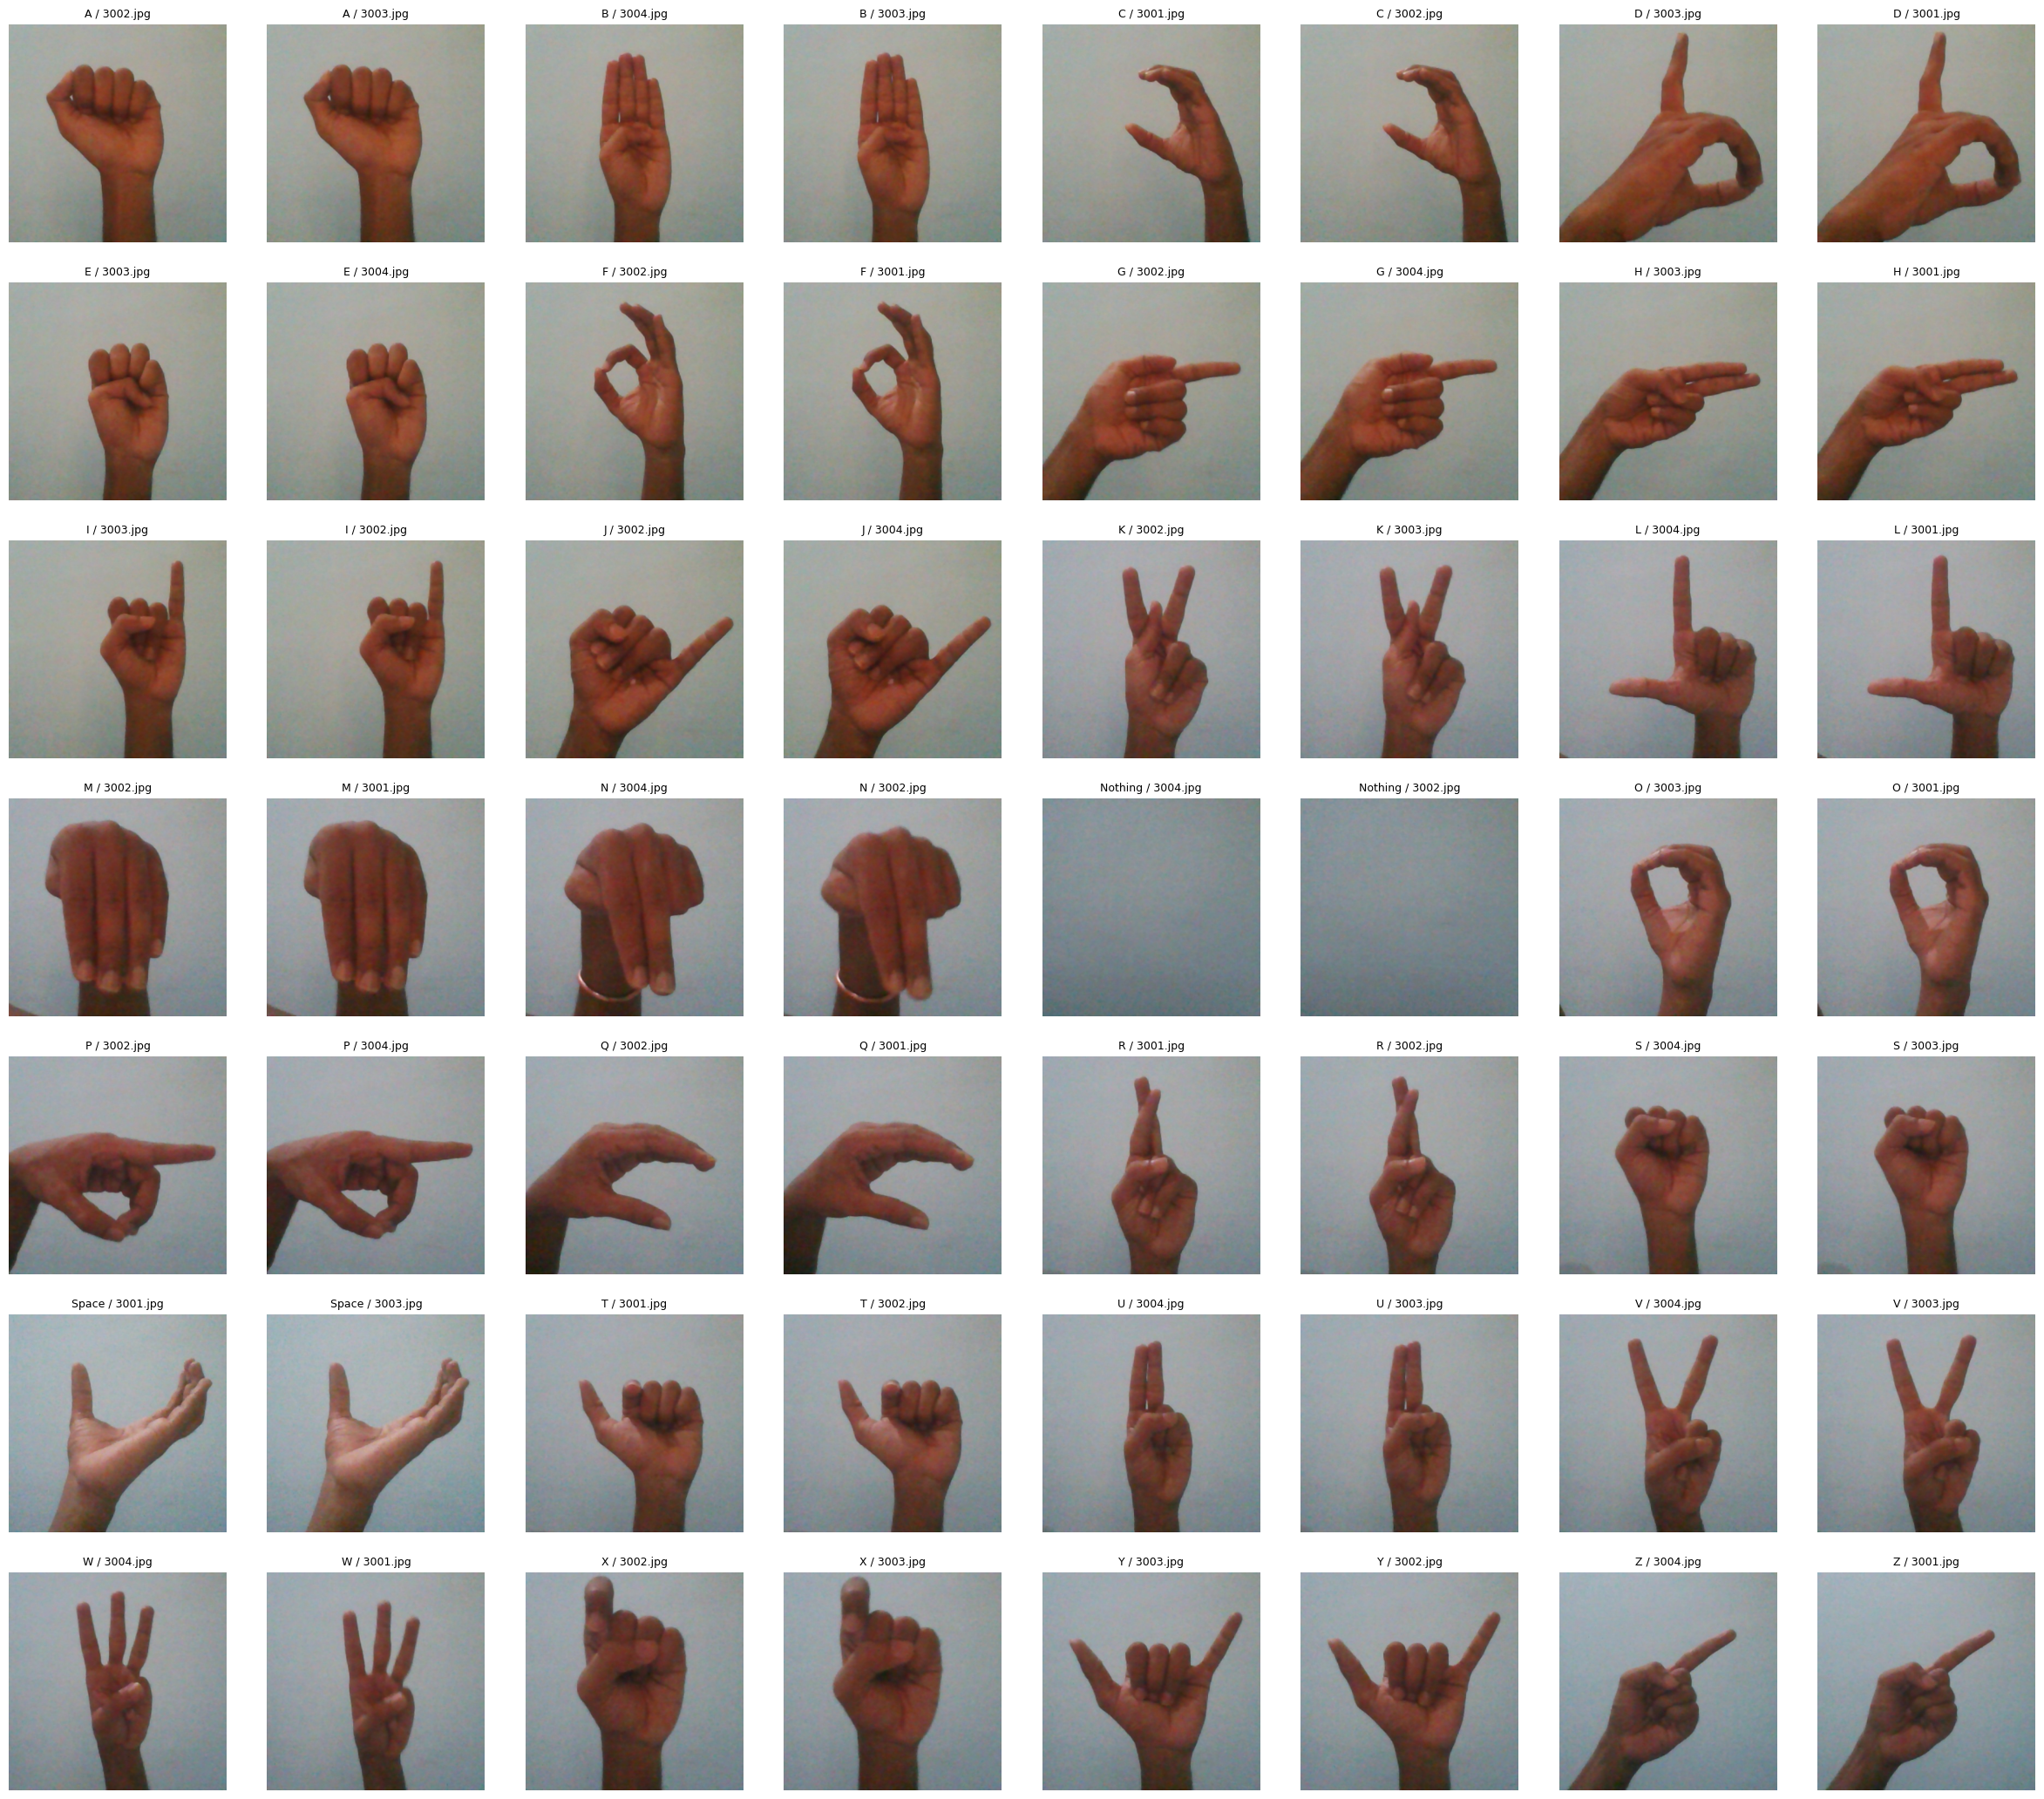

In [ ]:
try:
    subdirectorios = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
except NameError:
    print("Error: La variable 'test_dir' no está definida.")
    print("Por favor, define 'test_dir' con la ruta a tu directorio.")
    subdirectorios = []
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el directorio: {test_dir}")
    print("Por favor, asegúrate de que la variable 'test_dir' sea correcta.")
    subdirectorios = []

if subdirectorios:
    num_letras = len(subdirectorios) # 28
    num_imagenes_por_letra = 2

    #Definir el tamaño de la parrilla (lienzo)

    num_filas_grid = 7
    num_columnas_grid = 8

    # Ajusta figsize: (ancho_total, alto_total)
    fig, axes = plt.subplots(num_filas_grid, num_columnas_grid, figsize=(num_columnas_grid * 3, num_filas_grid * 3))
    axes_flat = axes.flatten()
    k = 0 #Contador para la parrilla aplanada

    print(f"Generando vista previa para {num_letras} categorías en una parrilla de {num_filas_grid}x{num_columnas_grid}...")

    #Iterar y llenar la parrilla
    for i, letra in enumerate(subdirectorios):
        ruta_subdirectorio = os.path.join(test_dir, letra)

        try:
            archivos = [f for f in os.listdir(ruta_subdirectorio) if f.endswith(('.png', '.jpg', '.jpeg'))][:num_imagenes_por_letra]
        except Exception as e:
            print(f"No se pudo leer {ruta_subdirectorio}: {e}")
            continue

        # Iteramos por CADA UNA de las (hasta) 2 imágenes
        for j, archivo in enumerate(archivos):

            # Comprobamos si aún caben imágenes en la parrilla
            if k >= len(axes_flat):
                print("Advertencia: Hay más imágenes que espacios en la parrilla. Deteniendo.")
                break

            try:
                ruta_imagen = os.path.join(ruta_subdirectorio, archivo)
                img = cv2.imread(ruta_imagen)

                if img is None: # Comprobar si la imagen se cargó mal
                    print(f"Error al leer imagen (es None): {ruta_imagen}")
                    continue # Saltamos esta imagen, 'k' no incrementa

                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Asignar la imagen a su lugar en la parrilla APLANADA
                ax = axes_flat[k]
                ax.imshow(img_rgb)
                # Un título más descriptivo: "A / imagen1.png"
                ax.set_title(f"{letra} / {archivo}", fontsize=9)
                ax.axis('off')

                k += 1 # Siguiente espacio de la parrilla

            except Exception as e:
                print(f"Error procesando {ruta_imagen}: {e}")
                # Si algo falla, al menos apagamos el eje y avanzamos
                if k < len(axes_flat):
                    axes_flat[k].axis('off')
                    k += 1

    # Ocultar los ejes restantes
    for k_extra in range(k, len(axes_flat)):
        axes_flat[k_extra].axis('off')

    # Ajustar el diseño y mostrar
    plt.tight_layout(pad=2.0) # Ajusta el espaciado
    plt.show()

else:
    print("No se encontraron subdirectorios para procesar.")

### Preprocesamiento de datos

Con la librería de mediapipe se sacan los landmarks de las manos, para convertir el dataset de imágenes a coordenadas, las cuáles se pueden guardar a manera de csv. Se opta por convertir de esta forma ya que PySpark no está diseñado para deep learning y visión computacional

Manos detectadas:


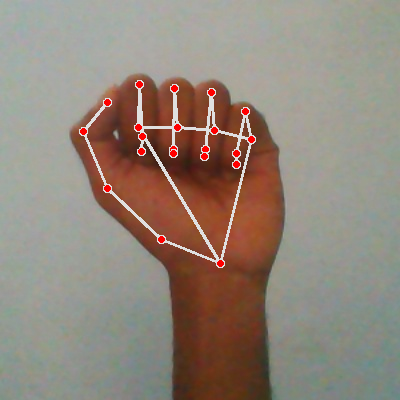

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
ruta_imagen = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/Test/A/3001.jpg'
img = cv2.imread(ruta_imagen)

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5) as hands:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        print("Manos detectadas:")
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                img,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)

    else:
        print("No se detectaron manos.")

# Mostrar la imagen
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

handlandmarks devuelve 21 puntos, los cuáles tienen coordenadas x,y,z. Es un poco extraño trabajar con profundidad cuando se tiene imágenes 2D

In [ ]:
def aplanar_landmarks(landmarks):
  #Las landmarks las regresa en una fila df x1,y1,z1,x2,y2,z2,...,xn,yn,zn
  x = []
  y = []
  z = []
  for hand_landmarks in results.multi_hand_landmarks:
      landmark = hand_landmarks.landmark
      for cords in landmark:
        x.append(cords.x)
        y.append(cords.y)
        z.append(cords.z)

  x = np.array(x)
  y = np.array(y)
  z = np.array(z)
  #añadir en una sola lista los valores de x,y,z
  coordenadas = np.concatenate((x, y, z))
  return coordenadas


Se descomprime el dataset localmente, por cuestiones de rapidez

In [ ]:
#Descomprime el dataset en el disco local de Colab
print("Descomprimiendo dataset...")
!unzip -q "/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/archive.zip" -d "/content/dataset_local/"
print("¡Dataset listo en disco local!")



Descomprimiendo dataset...
replace /content/dataset_local/ASL_Dataset/Test/A/3001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
¡Dataset listo en disco local!


In [ ]:
def landmarks_a_vector_fijo(results, num_manos=1):
    """
    Extrae los landmarks de 'num_manos' y los aplana.
    Si se detectan menos manos, rellena con ceros.
    Devuelve un vector de tamaño fijo: (num_manos * 21 landmarks * 3 coords)
    """
    # 21 landmarks * 3 coordenadas (x,y,z)
    coords_por_mano = 21 * 3
    tamaño_total = num_manos * coords_por_mano

    # Crea un vector de ceros
    vector_salida = np.zeros(tamaño_total, dtype=np.float32)

    if results.multi_hand_landmarks:
        # Itera solo hasta el número de manos que queremos
        for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
            if i >= num_manos:
                break # Ya tenemos las manos que queríamos

            # Extrae coords de esta mano
            coords_mano = np.array([
                [lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark
            ])

            # Aplana el array (21, 3) a (63,) y lo pone en el lugar correcto
            vector_salida[i*coords_por_mano : (i+1)*coords_por_mano] = coords_mano.flatten()

    return vector_salida
def calcular_num_particiones(spark, df):
    """
    Calcula el número óptimo de particiones basado en datos y recursos
    """
    num_registros = df.count()
    num_cores = spark.sparkContext.defaultParallelism

    # Calculamos particiones por diferentes métodos
    particiones_por_registros = max(1, num_registros // 10000)
    particiones_por_cores = num_cores * 2

    # Tomamos el menor valor para no sobrecargar el sistema
    num_particiones = min(particiones_por_registros, particiones_por_cores)

    return num_particiones


def procesar_lote_imagenes(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5
    ) as hands:

        # Procesa cada lote que Spark le envía
        for batch_df in iterator:
            resultados_lote = []

            # Itera sobre cada fila (imagen) en el lote
            for row in batch_df.itertuples():
                ruta_imagen_str = row.path
                contenido_imagen_bytes = row.content # Bytes crudos

                # Obtener la etiqueta (letra) de la ruta
                letra_correspondiente = os.path.split(os.path.dirname(ruta_imagen_str))[-1]

                try:
                    # Decodificar la imagen desde los bytes
                    img_array = np.frombuffer(contenido_imagen_bytes, dtype=np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

                    # Procesar con MediaPipe
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = hands.process(img_rgb)

                    if results.multi_hand_landmarks:
                        # Obtener el vector de 63 coordenadas
                        coordenadas = landmarks_a_vector_fijo(results, num_manos=1)
                        resultados_lote.append((coordenadas.tolist(), letra_correspondiente))
                    else:
                        resultados_lote.append((None, letra_correspondiente))

                except Exception as e:
                    # print(f"Error procesando {ruta_imagen_str}: {e}")
                    resultados_lote.append((None, letra_correspondiente))

            # Devuelve los resultados de este lote como un DataFrame de Pandas
            yield pd.DataFrame(resultados_lote, columns=["coordenadas", "letra"])


def main(train_dir_path, output_drive_folder):
    spark = (
        SparkSession.builder
        .appName("Manos en Acción")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") # Optimización
        .getOrCreate()
    )
    print("Sesión de Spark iniciada.")

    # Calcula un buen número de particiones.
    num_particiones = spark.sparkContext.defaultParallelism * 2
    print(f"Usando {num_particiones} particiones para la escritura (basado en Cores).")

    output_local_folder = "/content/landmarks_spark_local"

    print(f"Cargando imágenes desde: {train_dir_path}")
    df_imagenes = (
        spark.read.format("binaryFile")
        .option("pathGlobFilter", "*.jpg")
        .option("recursiveFileLookup", "true")
        .load(train_dir_path)
    )
    # Procesamiento
    print("Iniciando procesamiento de MediaPipe (esto tardará)...")
    schema_salida = StructType([
        StructField("coordenadas", ArrayType(FloatType()), True),
        StructField("letra", StringType(), True)
    ])
    df_resultados = df_imagenes.mapInPandas(procesar_lote_imagenes, schema=schema_salida)

    # Transformacion
    df_final = df_resultados.dropna(subset=["coordenadas"])
    print("Procesamiento de MediaPipe completado. Aplanando resultados...")
    num_coordenadas = 63
    columnas_aplanadas = [
        col("coordenadas")[i].alias(f"c_{i}") for i in range(num_coordenadas)
    ]
    df_aplanado = df_final.select(
        col("letra"),
        *columnas_aplanadas
    )

    # Guardado local
    print(f"Guardando {num_particiones} archivos CSV temporalmente en: {output_local_folder}")
    (
        df_aplanado.repartition(num_particiones) # Usamos repartition para distribuir la carga
        .write
        .mode("overwrite")
        .option("header", "true")
        .csv(output_local_folder) # <-- ¡Escribe localmente!
    )
    print("CSV guardado localmente.")
    spark.stop()
    print("Sesión de Spark detenida.")

    # Mover a drive
    print(f"Copiando carpeta de resultados a Google Drive: {output_drive_folder}")
    try:
        os.makedirs(output_drive_folder, exist_ok=True)
        !cp -R "{output_local_folder}"/* "{output_drive_folder}"/
        print(f"¡Éxito! Resultados copiados a: {output_drive_folder}")
        !rm -rf "{output_local_folder}"
        print("Limpieza local completada.")
    except Exception as e:
        print(f" Error al mover los archivos a Google Drive: {e}")

if __name__ == "__main__":
    train_dir = "/content/dataset_local/ASL_Dataset/Train"
    output_drive_path = '/content/drive/MyDrive/IA Avanzada/landmarks_train_spark_output'

    main(train_dir, output_drive_path)

Sesión de Spark iniciada.
Usando 16 particiones para la escritura (basado en Cores).
Cargando imágenes desde: /content/dataset_local/ASL_Dataset/Train
Iniciando procesamiento de MediaPipe (esto tardará)...
Procesamiento de MediaPipe completado. Aplanando resultados...
Guardando 16 archivos CSV temporalmente en: /content/landmarks_spark_local
CSV guardado localmente.
Sesión de Spark detenida.
Copiando carpeta de resultados a Google Drive: /content/drive/MyDrive/IA Avanzada/landmarks_train_spark_output
¡Éxito! Resultados copiados a: /content/drive/MyDrive/IA Avanzada/landmarks_train_spark_output
Limpieza local completada.


El código anterior convierte los landmarks a vectores de la forma x1,y1,z1,...,x21,y21,z21 y se pasan a un archivo csv para una fácil manipulación. Debido a la gran cantidad de imágenes se utilizan particiones de pyspark para poder dividir la tarea de crear los csv.
Al final esos archivos creados se suben a Google Drive para poder trabajar con los landmarks sin tener que volver a correr este código de arriba

### Preprocesamiento csv

In [ ]:
import os, shutil, subprocess, sys
import cv2 as cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, concat, when, round
from pyspark.sql.types import (
    StructType, StructField, ArrayType, FloatType, StringType
)
from typing import Iterator, Tuple
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# --- 1) Instalar Java 17 y PySpark 3.5.x (compatible con Python 3.12) ---
!apt-get update -qq
!apt-get install -y -qq openjdk-17-jdk-headless
!pip install -q --upgrade pyspark==3.5.1

# --- 2) Apuntar JAVA_HOME y PATH ---
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# --- 3) Verificar versiones (debug útil) ---
print("java -version:")
print(subprocess.run(["bash", "-lc", "java -version"], capture_output=True, text=True).stderr)
import pyspark
spark = (
    SparkSession.builder
    .appName("Manos en Acción")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") # Optimización
    .getOrCreate()
)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package java-common.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Selecting previously unselected package openjdk-17-jre-headless:amd64.
Preparing to unpack .../openjdk-17-jre-headless_17.0.16+8~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.16+8~us1-0ubuntu1~22.04.1) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (2

Visualización del dataframe creado:

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/IA Avanzada/landmarks_train_spark_output"
df = spark.read.csv(DATASET_PATH, header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate = False)
#contar registros en total
print("Total registros: ", df.count())

root
 |-- letra: string (nullable = true)
 |-- c_0: double (nullable = true)
 |-- c_1: double (nullable = true)
 |-- c_2: double (nullable = true)
 |-- c_3: double (nullable = true)
 |-- c_4: double (nullable = true)
 |-- c_5: double (nullable = true)
 |-- c_6: double (nullable = true)
 |-- c_7: double (nullable = true)
 |-- c_8: double (nullable = true)
 |-- c_9: double (nullable = true)
 |-- c_10: double (nullable = true)
 |-- c_11: double (nullable = true)
 |-- c_12: double (nullable = true)
 |-- c_13: double (nullable = true)
 |-- c_14: double (nullable = true)
 |-- c_15: double (nullable = true)
 |-- c_16: double (nullable = true)
 |-- c_17: double (nullable = true)
 |-- c_18: double (nullable = true)
 |-- c_19: double (nullable = true)
 |-- c_20: double (nullable = true)
 |-- c_21: double (nullable = true)
 |-- c_22: double (nullable = true)
 |-- c_23: double (nullable = true)
 |-- c_24: double (nullable = true)
 |-- c_25: double (nullable = true)
 |-- c_26: double (nullable = tr

Se puede eliminar las columnas multiplos de 3, ya que corresponden a las coordenadas en z y solo tenemos imagenes 2D.

Este paso se pudo haber hecho antes de convertir las coordenadas a csv también.

Las coordenadas 'z' son c_2, c_5, c_8, ..., c_62

Hay menos registros ya que se eliminaron las imágenes de "nothing" (no tenían mano)

In [ ]:
num_coordenadas = 63
cols_to_drop = [f"c_{i}" for i in range(num_coordenadas) if i % 3 == 2]

# Eliminar esas columnas del DataFrame
df_2d = df.drop(*cols_to_drop)

print("Columnas eliminadas:", cols_to_drop)
print("Nuevo esquema del DataFrame (solo X, Y):")
df_2d.printSchema()

Columnas eliminadas: ['c_2', 'c_5', 'c_8', 'c_11', 'c_14', 'c_17', 'c_20', 'c_23', 'c_26', 'c_29', 'c_32', 'c_35', 'c_38', 'c_41', 'c_44', 'c_47', 'c_50', 'c_53', 'c_56', 'c_59', 'c_62']
Nuevo esquema del DataFrame (solo X, Y):
root
 |-- letra: string (nullable = true)
 |-- c_0: double (nullable = true)
 |-- c_1: double (nullable = true)
 |-- c_3: double (nullable = true)
 |-- c_4: double (nullable = true)
 |-- c_6: double (nullable = true)
 |-- c_7: double (nullable = true)
 |-- c_9: double (nullable = true)
 |-- c_10: double (nullable = true)
 |-- c_12: double (nullable = true)
 |-- c_13: double (nullable = true)
 |-- c_15: double (nullable = true)
 |-- c_16: double (nullable = true)
 |-- c_18: double (nullable = true)
 |-- c_19: double (nullable = true)
 |-- c_21: double (nullable = true)
 |-- c_22: double (nullable = true)
 |-- c_24: double (nullable = true)
 |-- c_25: double (nullable = true)
 |-- c_27: double (nullable = true)
 |-- c_28: double (nullable = true)
 |-- c_30: double

Al eliminar las coordenadas de z, se reduce drásticamente nuestras variables, de 63 a 42 variables

In [ ]:
df_2d.groupBy('letra').count().show()

+-----+-----+
|letra|count|
+-----+-----+
|    K| 5996|
|    F| 5996|
|    Q| 5654|
|    E| 5996|
|    T| 5648|
|    B| 5996|
|    Y| 5720|
|    M| 5373|
|    L| 5996|
|    V| 5974|
|    U| 4542|
|    O| 5469|
|    D| 5362|
|    C| 5980|
|    J| 5996|
|    Z| 5565|
|    A| 5996|
|    N| 3440|
|    X| 5984|
|    W| 5996|
+-----+-----+
only showing top 20 rows



### Modelo

Debido a la alta dimensionalidad de los datos, primero se hará un modelo incluyendo las 42 columnas de coordenadas y después se hará un modelo con los componentes principales obtenidos por un PCA

**Modelo original**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
(train, test) = df_2d.randomSplit([0.9,0.1], seed = 42)
# StringIndexer (Convertir 'letra' a 'label') ---
label_indexer = StringIndexer(
    inputCol="letra",
    outputCol="label"
)

# Une las 42 columnas en 1 sola
feature_cols = [f"c_{i}" for i in range(63) if i % 3 != 2]

# Une todas las columnas de 'feature_cols' en una sola llamada 'features'
vec_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# Random Forest
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=15
)

# Convertir prediction a letra
label_converter = IndexToString(
    inputCol="prediction",
    outputCol="predicted_letra",
    labels=label_indexer.fit(df_2d).labels  # Le decimos que use las etiquetas que aprendió el Indexer
)
# Estandarizacion
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

print("Etapas del Pipeline definidas.")
# Pipeline
pipeline = Pipeline(
    stages=[
        label_indexer,
        vec_assembler,
        scaler,
        rf,
        label_converter
    ]
)

print("Iniciando entrenamiento...")
model = pipeline.fit(train)
print("Entrenamiento completado")

Etapas del Pipeline definidas.
Iniciando entrenamiento...
Entrenamiento completado


Se hace una separación de datos en un train/test split, en el cuál se opta por conservar el 90% de datos para entrenar el modelo y el 10% de datos para testear. No se selecciona un 80/20 o 70/30 debido a que se busca entrenar los modelos con la mayor cantidad de datos, además como son muchas imágenes(y cada letra tiene mas o menos la misma cantidad de imágenes), no se requiere grandes cantidades de estas para hacer las pruebas. Se definió previamente el Pipeline, el cuál primero convierte de letras a los labels (0,1,2...), después las columnas de las coordenadas se agrupan en un vector "features" para que spark pueda correr los modelos, posteriormente se estandarizan los datos, ahora si se llama al modelo un Random Forest y se convierten los labels numéricos a las letras.

### Evaluación
**Modelo original**

In [ ]:
# Hacer Predicciones
predictions = model.transform(test)

print("Predicciones generadas. Mostrando 10 ejemplos:")
predictions.select("letra", "predicted_letra", "probability").show(10, truncate=False)

# Evaluar el Rendimiento
# Usamos un evaluador de PySpark
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",#true label
    predictionCol="prediction", # Prediction
    metricName="accuracy"
)

# Calcular la precisión
accuracy = evaluator.evaluate(predictions)
print(f"\nPrecisión (Accuracy) en datos de prueba = {accuracy * 100:.2f} %")

# También podemos ver el F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score en datos de prueba = {f1_score:.4f}")

Predicciones generadas. Mostrando 10 ejemplos:
+-----+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|letra|predicted_letra|probability                                                                                                                                                                                                                                                                                                                                           

Una vez entrenado el modelo, se evaluá el desempeño del modelo con los datos de test. A pesar de tener un dataset balanceado se opta por usar F1 Score debido a que considera la precision y el recall. Como se observa, el primer modelo con las 42 variables tiene un desempeño del 0.8051 de F1-Score

### PCA

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[vec_assembler,
        scaler,
        pca])
pca_model = pca_pipeline.fit(df_2d)
pca_df = pca_model.transform(df_2d)
pca_model_componente = pca_model.stages[-1]
varianza_explicada = pca_model_componente.explainedVariance

print(f"Varianza explicada por componente (k=2): {varianza_explicada}")
print(f"Componente 1 (pca_0) explica: {varianza_explicada[0] * 100:.2f}%")
print(f"Componente 2 (pca_1) explica: {varianza_explicada[1] * 100:.2f}%")
print(f"Componente 3 (pca_2) explica: {varianza_explicada[2] * 100:.2f}%")
print(f"Componente 4 (pca_3) explica: {varianza_explicada[3] * 100:.2f}%")
print(f"Componente 5 (pca_4) explica: {varianza_explicada[4] * 100:.2f}%")
print(f"---")
print(f"Varianza TOTAL explicada: {sum(varianza_explicada) * 100:.2f}%")

Varianza explicada por componente (k=2): [0.3342778901508592,0.29546616016178734,0.11132663958159839,0.08013657770252004,0.047104041008247596]
Componente 1 (pca_0) explica: 33.43%
Componente 2 (pca_1) explica: 29.55%
Componente 3 (pca_2) explica: 11.13%
Componente 4 (pca_3) explica: 8.01%
Componente 5 (pca_4) explica: 4.71%
---
Varianza TOTAL explicada: 86.83%


Se aplica un PCA a los datos para reducir la dimensionalidad, se observa como para los primeros componentes la variabilidad explicada es muchísima. Se opta por seleccionar 5 componentes, los cuáles son responsables de explicar alrededor del 86.83% de los datos. Aunque la variabilidad explicada cae drásticamente del componente pca_1 al pca_2 se opta por seguir añadiendo componentes hasta explicar una cantidad decente, se para de añadir componentes cuando se vuelve a repetir que la variabilidad disminuye en casi la mitad.

In [ ]:
from ctypes import c_int64
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
import glob

# Definir UDFs para extraer los elementos del vector PCA
c1_udf = udf(lambda v: float(v[0]), FloatType())
c2_udf = udf(lambda v: float(v[1]), FloatType())
c3_udf = udf(lambda v: float(v[2]), FloatType())
c4_udf = udf(lambda v: float(v[3]), FloatType())
c5_udf = udf(lambda v: float(v[4]), FloatType())

# Seleccionar la 'letra' y las nuevas columnas de PCA
df_para_guardar = pca_df.select(
    col("letra"),
    c1_udf(col("pca_features")).alias("pca_0"),
    c2_udf(col("pca_features")).alias("pca_1"),
    c3_udf(col("pca_features")).alias("pca_2"),
    c4_udf(col("pca_features")).alias("pca_3"),
    c5_udf(col("pca_features")).alias("pca_4")
)

print("DataFrame de PCA listo para guardar:")
df_para_guardar.show(5)

# Rutas
output_local_folder = "/content/pca_landmarks_local"
output_drive_path = "/content/drive/MyDrive/IA Avanzada/pca_landmarks.csv"

# Guardar
print("Guardando CSV de PCA en disco local...")
(
    df_para_guardar.coalesce(1)
    .write
    .mode("overwrite")
    .option("header", "true")
    .csv(output_local_folder)
)
print("CSV guardado localmente")
# Mover el archivo final a Google Drive
print(f"Moviendo el CSV final a Google Drive: {output_drive_path}")
try:
    # Buscar el archivo CSV real creado
    csv_files = glob.glob(f"{output_local_folder}/*.csv")

    if csv_files:
        archivo_csv_local = csv_files[0]
        !cp "{archivo_csv_local}" "{output_drive_path}"
        print(f"¡Éxito! Archivo copiado a: {output_drive_path}")
    else:
        print("Error: No se encontró el archivo CSV en la carpeta de salida local.")

except Exception as e:
    print(f" Error al mover el archivo a Google Drive: {e}")


DataFrame de PCA listo para guardar:
+-----+---------+----------+----------+-----------+------------+
|letra|    pca_0|     pca_1|     pca_2|      pca_3|       pca_4|
+-----+---------+----------+----------+-----------+------------+
|    C|5.1748233|-6.0381885|-1.6319455| 0.06881249|-0.050361853|
|    C|5.3125596|-6.0281615|-1.6632067|  0.1984338| -0.01837549|
|    C| 5.328824|-6.1674976|-1.5589654|0.115173906| 8.156061E-4|
|    C|7.6519084|-6.4710813|-1.2013234|-0.31303346|  0.17237584|
|    C|6.7144227|-6.2511263|-1.1938365|-0.55069095| -0.06778144|
+-----+---------+----------+----------+-----------+------------+
only showing top 5 rows

Guardando CSV de PCA en disco local...
CSV guardado localmente
Moviendo el CSV final a Google Drive: /content/drive/MyDrive/IA Avanzada/pca_landmarks.csv
¡Éxito! Archivo copiado a: /content/drive/MyDrive/IA Avanzada/pca_landmarks.csv


Para poder trabajar con los datos generados por el pca, se opta por guardar los resultados en un csv. Estos guardados de archivos son útiles ya que no se debe de volver a correr todo el notebook, sino que se puede trabajar apartir del último paso

In [ ]:
pca_df = spark.read.csv("/content/drive/MyDrive/IA Avanzada/pca_landmarks.csv", header=True, inferSchema=True)
pca_df.printSchema()
pca_df.show(5, truncate = False)

root
 |-- letra: string (nullable = true)
 |-- pca_0: double (nullable = true)
 |-- pca_1: double (nullable = true)
 |-- pca_2: double (nullable = true)
 |-- pca_3: double (nullable = true)
 |-- pca_4: double (nullable = true)

+-----+---------+----------+----------+-----------+------------+
|letra|pca_0    |pca_1     |pca_2     |pca_3      |pca_4       |
+-----+---------+----------+----------+-----------+------------+
|C    |5.1748233|-6.0381885|-1.6319455|0.06881249 |-0.050361853|
|C    |5.3125596|-6.0281615|-1.6632067|0.1984338  |-0.01837549 |
|C    |5.328824 |-6.1674976|-1.5589654|0.115173906|8.156061E-4 |
|C    |7.6519084|-6.4710813|-1.2013234|-0.31303346|0.17237584  |
|C    |6.7144227|-6.2511263|-1.1938365|-0.55069095|-0.06778144 |
+-----+---------+----------+----------+-----------+------------+
only showing top 5 rows



**Entrenamiento modelo PCA**

Se separa de la misma manera los datos 90%-10%, el pipeline de entrenamiento es el mismo, solo que ahora en lugar de trabajar con 42 features se trabaja con 5 solamente

In [ ]:
[train_pca, test_pca] = pca_df.randomSplit([0.9,0.1], seed = 42)
label_indexer_2 = StringIndexer(
    inputCol="letra",
    outputCol="label"
)

feature_cols_2 = [f"pca_{i}" for i in range(4)]

vec_assembler_2 = VectorAssembler(
    inputCols=feature_cols_2,
    outputCol="features"
)

# Random Forest
rf_2 = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=15
)

label_converter_2 = IndexToString(
    inputCol="prediction",
    outputCol="predicted_letra",
    labels=label_indexer.fit(pca_df).labels
)

scaler_2 = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

pipeline_2 = Pipeline(
    stages=[
        label_indexer_2,
        vec_assembler_2,
        scaler_2,
        rf_2,
        label_converter_2
    ]
)

print("Iniciando entrenamiento...")
pca_model = pipeline_2.fit(train_pca)
print("Entrenamiento completado")

Iniciando entrenamiento...
Entrenamiento completado


In [ ]:
pca_predictions = pca_model.transform(test_pca)

print("Predicciones generadas. Mostrando 10 ejemplos:")
pca_predictions.select("letra", "predicted_letra", "probability").show(10, truncate=False)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",#true label
    predictionCol="prediction",
    metricName="accuracy"
)

pca_accuracy = evaluator.evaluate(pca_predictions)
print(f"\nPrecisión (Accuracy) en datos de prueba = {pca_accuracy * 100:.2f} %")

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
pca_f1_score = evaluator_f1.evaluate(pca_predictions)
print(f"F1-Score en datos de prueba = {pca_f1_score:.4f}")

Predicciones generadas. Mostrando 10 ejemplos:
+-----+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|letra|predicted_letra|probability                                                                                                                                                                                                                                                                                                                                          

Una vez entrenado el modelo, se hacen las pruebas con el dataset de test, el cuál dió un F1_Score de 0.5053

### Guardar y exportar resultados

Se guardan los resultados de las predicciones en un csv para poder crear las visualizaciones con Tableau. Se juntan las predicciones del modelo PCA y el modelo "Original" con la letra verdadera. Además se coloca 1 en las columnas de acierto si la predicción del modelo coincide con la letra verdadera, esto con el objetivo de mostrar gráficas e indicadores del rendimiento de los modelos

In [ ]:
# Guardar en un csv la letra real, las predicciones con el modelo original y las predicciones con el modelo pca
from pyspark.sql.functions import monotonically_increasing_id, col

# Renombrar columnas
df_resultados_pca = pca_predictions.select("letra", "predicted_letra")
df_resultados_original = predictions.select("letra", "predicted_letra")
df_pca_renamed = df_resultados_pca.withColumnRenamed("predicted_letra", "pred_pca")
df_orig_renamed = df_resultados_original.withColumnRenamed("predicted_letra", "pred_original")

# Añadir ID
df_pca_with_id = df_pca_renamed.withColumn("id_temporal", monotonically_increasing_id())
df_orig_with_id = df_orig_renamed.withColumn("id_temporal", monotonically_increasing_id())

# unir las columnas
df_comparacion = df_orig_with_id.join(
    df_pca_with_id,
    "id_temporal"
)

df_final = df_comparacion.select(
    df_orig_with_id.letra,  # Seleccionamos la "letra" original
    "pred_original",        # La predicción del modelo original
    "pred_pca"              # La predicción del modelo PCA
)

#Calcular cuando se acertó la prediccion,
#si la letra coincide con pred_original acierto_original = 1, else 0, misma logica con acierto_pca
df_final = df_final.withColumn("acierto_original", when(col("letra") == col("pred_original"), 1).otherwise(0))
df_final = df_final.withColumn("acierto_pca", when(col("letra") == col("pred_pca"),1).otherwise(0))

print("Tabla de comparación de predicciones:")
df_final.show(10)



Tabla de comparación de predicciones:
+-----+-------------+--------+----------------+-----------+
|letra|pred_original|pred_pca|acierto_original|acierto_pca|
+-----+-------------+--------+----------------+-----------+
|    A|            L|       Y|               0|          0|
|    A|            I|       I|               0|          0|
|    A|            O|       I|               0|          0|
|    A|            L|       A|               0|          1|
|    A|            B|       W|               0|          0|
|    A|            L|       A|               0|          1|
|    A|            L|       I|               0|          0|
|    A|            L|       A|               0|          1|
|    A|            L|       A|               0|          1|
|    A|            L|       T|               0|          0|
+-----+-------------+--------+----------------+-----------+
only showing top 10 rows



In [ ]:
#Exportar a csv
(
    df_final.coalesce(1)
    .write
    .mode("overwrite")
    .option("header", "true")
    .csv("/content/pred_results")
)

#Guardar a drive
!cp -R "/content/pred_results" "/content/drive/MyDrive/IA Avanzada/pred_results"

### Visualizaciones:

Se creaa visualizaciones con Tableau, se publicó el dashboard aquí: [Dashboard publicado en Tableau Public](https://public.tableau.com/app/profile/adid.salgado/viz/ManosEnAccion/Dashboard1?publish=yes)

Además se muestran parte de las imágenes utilizadas en el Tableau

**Foto del dashboard, muestra métricas del modelo, datos acerca de los componentes principales y una gráfica para observar el desempeño de los modelos para cada letra, tiene añadido filtros para poder consultar específicamente letras/elementos**

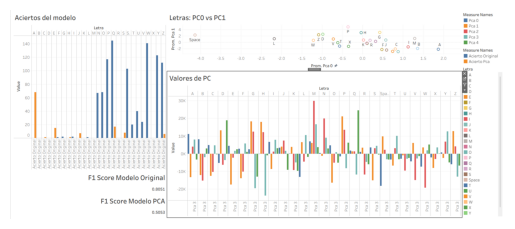

In [ ]:
from PIL import Image
dashboard = Image.open("/content/drive/MyDrive/IA Avanzada/visualizaciones/dashboard.png")

# Muestra la imagen
plt.imshow(np.asarray(dashboard))
plt.axis('off')
plt.show()

**Gráfica del promedio de los componentes principales obtenidos para cada vocal**

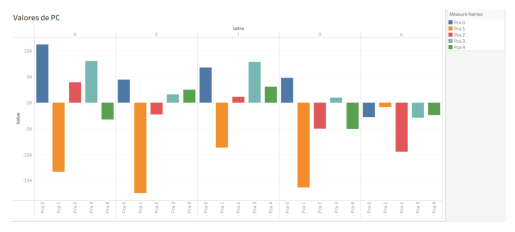

In [ ]:
img = Image.open("/content/drive/MyDrive/IA Avanzada/visualizaciones/pc_vocales.png")

# Muestra la imagen
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

**Gráfica de los valores de las dimensiones principales del PCA (componente 0 y 1) para las vocales**

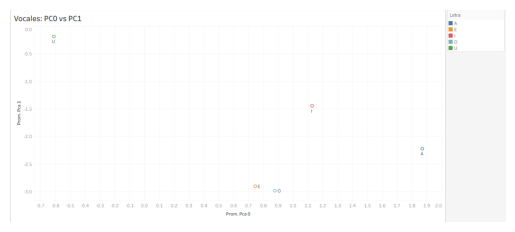

In [ ]:
img = Image.open("/content/drive/MyDrive/IA Avanzada/visualizaciones/2pc_vocales.png")

# Muestra la imagen
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()


### Conclusiones y siguientes pasos:
En este proyecto se aprovechó la distribución de recursos de pyspark principalmente para procesar las imágenes y convertirlas a coordenadas y posteriormente a un csv. Aunque el dataset resultante, ya no pesaba 5GB se continuó usando Pyspark para definir los pipelines, entrenar el modelo y evaluarlo.

Durante esta implementación noté posibles mejoras para implementar para la siguiente entrega:
* Eliminar las coordenadas z antes de armar los vectores y convertirlos a csv
* Añadir data augmentation para agregar variabilidad al dataset, el cuál no parece tener mucha
* Modificar el split, debido a la cantidad de datos se podría incrementar un poco más el % de imágenes con el que se entrena.
* Probar diferentes modelos para los dos datasets
* Evaluar a profundidad el PCA, considerar si vale la pena añadir componentes para representar un 95% de la variabiliadad de los datos.
* Hacer hyperparameter tunning a los modelos generados
* Probar la última versión del modelo con los datos de la carpeta test

In [ ]:
print("Victor Adid Salgado Santana")

Victor Adid Salgado Santana
